<div style="background-color:#5D73F2; color:#19180F; font-size:40px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px"> GANs(Generative Adversarial Networks) </div>
<div style="background-color:#A8B4F6; color:#19180F; font-size:30px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px"> Architecture Overview</div>
<div style="background-color:#D5D9F2; color:#19180F; font-size:15px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px"> 
Generative Adversarial Networks, are made up of two parts: the Generator and the Discriminator. To create realistic data, these components compete and cooperate with one another.<br><br>
The Generator is in charge of developing fresh samples that are similar to the original data. This component is represented in the diagram by the Generator subgraph. It processes an input noise vector (represented by the Input Noise node) via various layers, including a dense layer and an activation function. The Generated Image node represents how these layers turn the noise into a produced image. The purpose of the Generator is to create visuals that are realistic enough to pass for genuine.<br><br>
The Discriminator, on the other hand, must discern between genuine and manufactured data. This component is represented in the diagram by the Discriminator subgraph. The Real or Generated Image node represents the input, which can be either a genuine image or a produced image. This input is processed by the Discriminator using layers such as convolution, activation, and dense layers. These layers process the input and generate an output, which is represented by the Output node. The goal of the Discriminator is to accurately categorise the input picture as either real or artificial.<br><br>
This is when the competitive and cooperative aspects of the game come into play. The Generator and Discriminator are trained in a loop, as seen in the Training Loop subgraph. The training begins with a series of real-world photos, represented by the Real Images node. The Gen generates a set of images, represented by the Generated Images node. These generated images and real images are then combined, or concatenated, as shown by the Concatenation node.<br><br>
Both the Discriminator and the Generator Loss nodes get the concatenated data. The Discriminator Loss node compares the Discriminator's outputs for actual and generated pictures to see how well it is working. The Generator Loss node examines the Discriminator's response to the produced pictures to determine how successfully the Generator fools the Discriminator.<br><br>
The training loop uses these loss values to update both the Generator and the Discriminator. The Generator's goal is to create images that the Discriminator cannot differentiate from genuine ones, whereas the Discriminator's goal is to properly identify both actual and created images. The update process for each component is represented by the Update Generator and Update Discriminator nodes.<br><br>
By iterating this training loop indefinitely, the Generator learns to make increasingly realistic pictures, while the Discriminator improves its ability to distinguish between actual and generated data. This antagonistic relationship between the Generator and the Discriminator improves the quality of the produced samples over time.<br><br>
To summarise, GANs use the rivalry and collaboration of the Generator and Discriminator to produce data that closely mimics real samples. The Generator creates pictures from random noise, whereas the Discriminator attempts to discern whether an image is genuine or created. The Generator learns to make increasingly convincing pictures through iterative training, while the Discriminator improves at differentiating between genuine and created data.</div>

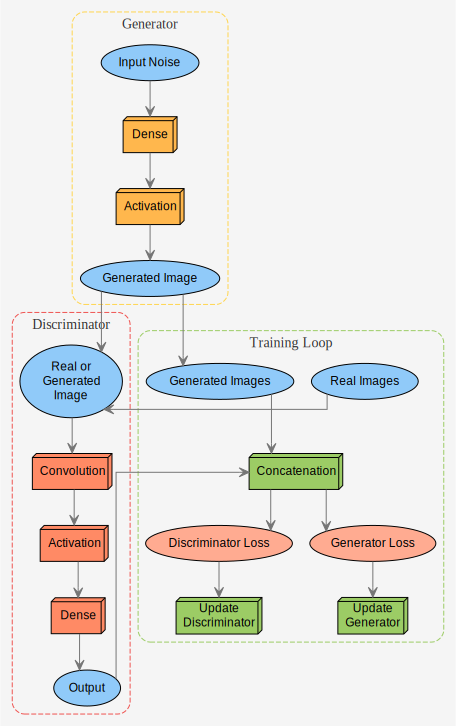

In [1]:
from IPython.display import SVG, display
svg_file = '/kaggle/input/machine-learning-architecture-diagrams/GAN.svg'
display(SVG(filename=svg_file))

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Importing modules
    </div>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.utils import make_grid
import numpy as np
import glob

from tqdm.notebook import tqdm
from torchvision.utils import save_image

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Visualizing samples    </div>

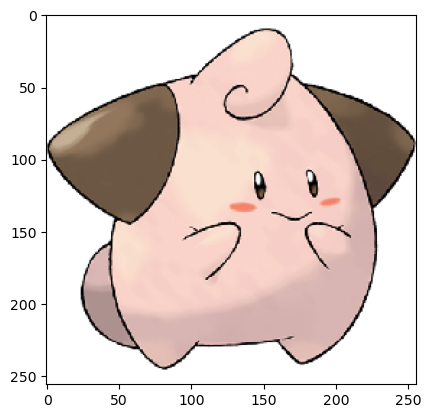

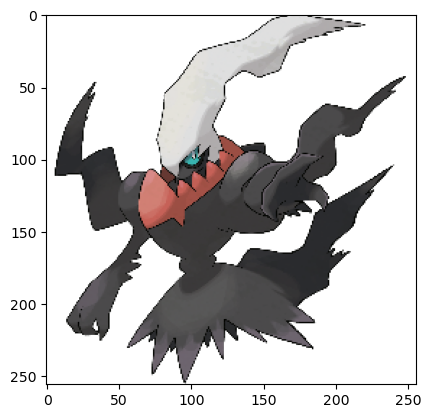

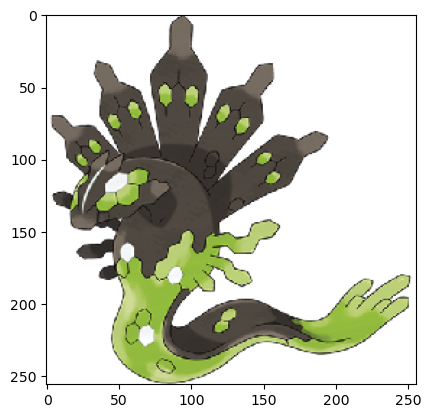

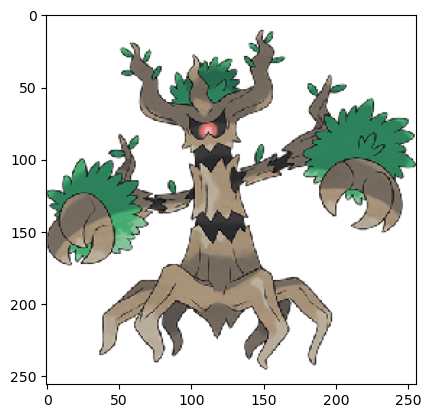

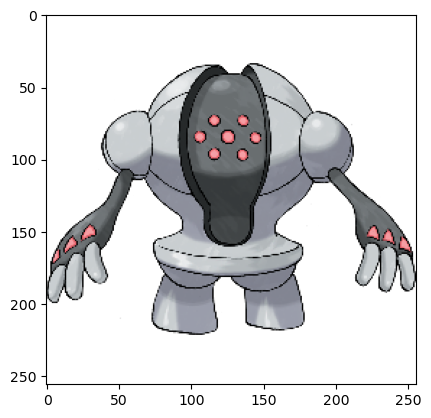

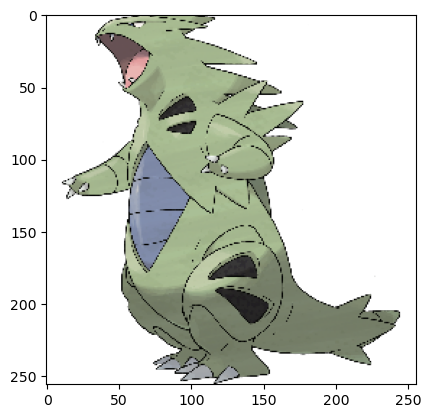

In [3]:
dataset_path = "/kaggle/input/pokemon-images-dataset/pokemon/"
disp_count = 1
for filename in glob.glob(dataset_path+"/pokemon/*.png"):
    plt.imshow(plt.imread(filename))
    plt.show()
    if disp_count==6:
        break
    disp_count+=1

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Setting device    </div>

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Initializing transforms    </div>

In [5]:
image_size = 64
batch_size=256
vals = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) #traiining models in pixel value at -1 to 1 is better
transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize(*vals)])

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Creating dataset and performing its sanity check    </div>

In [6]:
dataset = ImageFolder(dataset_path, transform=transform)
dataset.__getitem__(255)

(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 0)

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Creating dataloader    </div>

In [7]:
dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=True, num_workers=3, pin_memory=True)


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Function for denormalizing images    </div>

In [8]:
def denorm(image_tensor):
    return image_tensor * vals[1][0] + vals[0][0]

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Function to visualize images    </div>

In [9]:
def display_images(images, max=32):
    fig,ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:max]),nrow=8).permute(1,2,0))

def display_batch(dataloader, max=32):
    for images, _ in dataloader:
        display_images(images,max)
        break

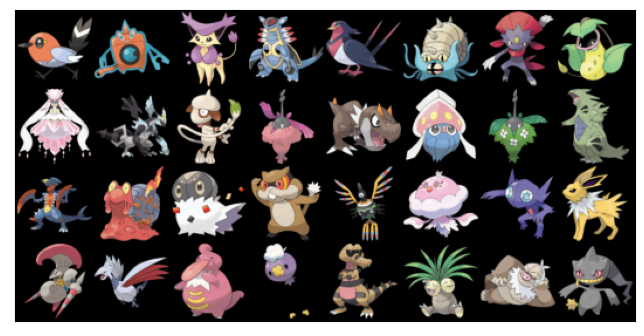

In [10]:
display_batch(dataloader)


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Defining discriminator network    </div>

In [11]:
discriminator_network = nn.Sequential(
    nn.Conv2d(3,64,kernel_size=4,stride=2, padding=1,bias=False), #bias = False for batch norm
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2,inplace=True),


    nn.Conv2d(64,128,kernel_size=4,stride=2, padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(128,2*128,kernel_size=4,stride=2, padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(256,512,kernel_size=4,stride=2, padding=1,bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(512,1,kernel_size=4,stride=1, padding=0, bias=False),

    nn.Flatten(),
    nn.Sigmoid() 
)

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Initializing discriminator network    </div>

In [12]:
d_model = discriminator_network.to(device)


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Defining generator network    </div>

In [13]:
latent_size = 128
generator = nn.Sequential(

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(),

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()

)

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Initializing generator model    </div>

In [14]:
g_model = generator.to(device)


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Train discriminator to identify which images belong to dataset and which don't by correctly assigning tensors of 0 or 1 for fake and real images     </div>


In [15]:
def discriminator_training(real_images, optimizer_discriminator):
    optimizer_discriminator.zero_grad()

    # passing real images through discriminator
    real_preds = d_model(real_images)
    #assign tensor of ones for these 
    real_targets = torch.ones(real_images.size(0),1,device=device)
    real_loss = torch.nn.functional.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # generating fake images and assigning tensor of zeros for them as targets
    latent_vector = torch.randn(batch_size,latent_size,1,1,device=device)
    fake_images = g_model(latent_vector)

    #passing fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0),1, device=device)
    fake_preds = d_model(fake_images)
    fake_loss = torch.nn.functional.binary_cross_entropy(fake_preds,fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # updating discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    optimizer_discriminator.step()

    return loss.item(), real_score, fake_score

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
The objective is to train a generator which have labels as 1 for generated images so as to fool the discriminator. The generator should be able to generate such images eventually which can fool the discriminator.
    </div>




In [16]:
def generator_training(generator_optimizer):
    generator_optimizer.zero_grad()

    #generate fake images
    latent_vector = torch.randn(batch_size,latent_size,1,1,device=device)
    fake_images = generator(latent_vector)

    # try to fool the discriminator
    preds = d_model(fake_images)
    targets = torch.ones(batch_size,1,device=device)
    loss = torch.nn.functional.binary_cross_entropy(preds,targets)

    #updating weights
    loss.backward()
    generator_optimizer.step()

    return fake_images,loss.item()

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Saving generated images
    </div>




In [17]:
import os
#logging images
os.makedirs('generated_images', exist_ok=True)

def save_generated_images(index, fake_images, show=True):
    fake_filename = 'generated-images-{0:0=6d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join('generated_images', fake_filename),nrow=8)
    print("Saved image")
    if show:
        fig,ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(),nrow=8).permute(1,2,0))

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Defining trainer function    </div>




In [18]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
def trainer(epochs,dataloader, learning_rate,start_idx=1):
    #losses,scores
    g_losses, d_losses= [],[]
    real_scores,fake_scores = [],[]

    #creating optimizers
    d_opt = optim.Adam(d_model.parameters(),lr=learning_rate, betas=(0.5, 0.999))
    g_opt = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999), weight_decay=1e-5)

    for epoch in range(epochs):
        for real_images, _ in tqdm(dataloader):
            #train discriminator
            real_images = real_images.to(device)
            d_loss, real_score,fake_score = discriminator_training(real_images,d_opt)
            #train generator
            pred,g_loss = generator_training(g_opt)

        #recording losses
        g_losses.append(g_loss)
        d_losses.append(d_loss)

        real_scores.append(real_score)
        fake_scores.append(fake_score)

        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, g_loss, d_loss, real_score, fake_score))
        
        

        #saving generated images
        save_generated_images(epoch+start_idx, pred,show=False)

    return g_losses,d_losses,real_scores,fake_scores

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Training model for 10000 epochs
    </div>




In [19]:
learning_rate=1e-10
epochs=100
history = trainer(epochs,dataloader,learning_rate)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [1/100], loss_g: 0.8780, loss_d: 1.3889, real_score: 0.4420, fake_score: 0.4221
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 0.8473, loss_d: 1.4877, real_score: 0.4010, fake_score: 0.4186
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 0.8928, loss_d: 1.4772, real_score: 0.3995, fake_score: 0.4156
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 0.8772, loss_d: 1.4803, real_score: 0.4056, fake_score: 0.4227
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 0.8824, loss_d: 1.4077, real_score: 0.4309, fake_score: 0.4177
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 0.8697, loss_d: 1.4353, real_score: 0.4221, fake_score: 0.4228
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 0.8796, loss_d: 1.4503, real_score: 0.4220, fake_score: 0.4268
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 0.8658, loss_d: 1.4784, real_score: 0.4105, fake_score: 0.4266
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 0.8916, loss_d: 1.5032, real_score: 0.3935, fake_score: 0.4236
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 0.8654, loss_d: 1.4286, real_score: 0.4200, fake_score: 0.4111
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 0.8658, loss_d: 1.4543, real_score: 0.4143, fake_score: 0.4191
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 0.8718, loss_d: 1.4756, real_score: 0.4085, fake_score: 0.4194
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 0.8827, loss_d: 1.4484, real_score: 0.4190, fake_score: 0.4243
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 0.8910, loss_d: 1.4624, real_score: 0.4142, fake_score: 0.4243
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 0.8744, loss_d: 1.4484, real_score: 0.4268, fake_score: 0.4343
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 0.8832, loss_d: 1.4465, real_score: 0.4232, fake_score: 0.4307
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 0.8701, loss_d: 1.3779, real_score: 0.4480, fake_score: 0.4222
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 0.8799, loss_d: 1.4601, real_score: 0.4147, fake_score: 0.4280
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 0.8870, loss_d: 1.4277, real_score: 0.4223, fake_score: 0.4192
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 0.8612, loss_d: 1.4875, real_score: 0.4075, fake_score: 0.4253
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 0.8769, loss_d: 1.5107, real_score: 0.3963, fake_score: 0.4291
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 0.8791, loss_d: 1.4978, real_score: 0.3990, fake_score: 0.4238
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 0.8754, loss_d: 1.4940, real_score: 0.4024, fake_score: 0.4249
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 0.8758, loss_d: 1.4205, real_score: 0.4332, fake_score: 0.4266
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 0.8722, loss_d: 1.4622, real_score: 0.4034, fake_score: 0.4128
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 0.8705, loss_d: 1.4824, real_score: 0.4090, fake_score: 0.4268
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 0.8883, loss_d: 1.3971, real_score: 0.4376, fake_score: 0.4232
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 0.8745, loss_d: 1.4755, real_score: 0.4116, fake_score: 0.4270
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 0.8758, loss_d: 1.5102, real_score: 0.3928, fake_score: 0.4195
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 0.8777, loss_d: 1.4661, real_score: 0.4111, fake_score: 0.4226
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 0.8740, loss_d: 1.4612, real_score: 0.4153, fake_score: 0.4303
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 0.8655, loss_d: 1.4502, real_score: 0.4126, fake_score: 0.4165
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 0.8810, loss_d: 1.4606, real_score: 0.4158, fake_score: 0.4278
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 0.8652, loss_d: 1.4565, real_score: 0.4134, fake_score: 0.4208
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 0.8992, loss_d: 1.4774, real_score: 0.4045, fake_score: 0.4224
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 0.8813, loss_d: 1.4549, real_score: 0.4175, fake_score: 0.4248
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 0.8777, loss_d: 1.4346, real_score: 0.4223, fake_score: 0.4225
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 0.8857, loss_d: 1.4673, real_score: 0.4131, fake_score: 0.4234
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 0.8876, loss_d: 1.4282, real_score: 0.4232, fake_score: 0.4184
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 0.8826, loss_d: 1.4800, real_score: 0.4060, fake_score: 0.4259
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 0.8795, loss_d: 1.4797, real_score: 0.4070, fake_score: 0.4249
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 0.8894, loss_d: 1.4382, real_score: 0.4164, fake_score: 0.4156
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 0.8865, loss_d: 1.4491, real_score: 0.4188, fake_score: 0.4215
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 0.8807, loss_d: 1.4528, real_score: 0.4167, fake_score: 0.4222
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 0.8765, loss_d: 1.4620, real_score: 0.4094, fake_score: 0.4180
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 0.8743, loss_d: 1.4661, real_score: 0.4076, fake_score: 0.4201
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 0.9008, loss_d: 1.4230, real_score: 0.4309, fake_score: 0.4268
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 0.8735, loss_d: 1.4510, real_score: 0.4200, fake_score: 0.4310
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 0.8835, loss_d: 1.4601, real_score: 0.4136, fake_score: 0.4217
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 0.8836, loss_d: 1.4582, real_score: 0.4167, fake_score: 0.4262
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 0.8865, loss_d: 1.4447, real_score: 0.4245, fake_score: 0.4319
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 0.8845, loss_d: 1.4278, real_score: 0.4295, fake_score: 0.4214
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 0.8625, loss_d: 1.4571, real_score: 0.4179, fake_score: 0.4295
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 0.9037, loss_d: 1.4554, real_score: 0.4123, fake_score: 0.4169
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 0.8781, loss_d: 1.4436, real_score: 0.4218, fake_score: 0.4246
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 0.8748, loss_d: 1.4765, real_score: 0.4100, fake_score: 0.4279
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 0.8802, loss_d: 1.4370, real_score: 0.4232, fake_score: 0.4262
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 0.8653, loss_d: 1.5035, real_score: 0.3969, fake_score: 0.4222
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 0.8961, loss_d: 1.4901, real_score: 0.4027, fake_score: 0.4235
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 0.8724, loss_d: 1.4305, real_score: 0.4250, fake_score: 0.4221
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 0.8786, loss_d: 1.4523, real_score: 0.4109, fake_score: 0.4177
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 0.8814, loss_d: 1.4580, real_score: 0.4142, fake_score: 0.4220
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 0.8669, loss_d: 1.4570, real_score: 0.4146, fake_score: 0.4226
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 0.8945, loss_d: 1.4975, real_score: 0.3968, fake_score: 0.4207
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 0.8860, loss_d: 1.4543, real_score: 0.4172, fake_score: 0.4247
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 0.8815, loss_d: 1.4369, real_score: 0.4228, fake_score: 0.4231
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 0.8901, loss_d: 1.4728, real_score: 0.4121, fake_score: 0.4285
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 0.8836, loss_d: 1.4886, real_score: 0.4006, fake_score: 0.4222
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 0.8849, loss_d: 1.4509, real_score: 0.4204, fake_score: 0.4277
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 0.8778, loss_d: 1.4151, real_score: 0.4306, fake_score: 0.4218
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 0.8780, loss_d: 1.4693, real_score: 0.4112, fake_score: 0.4212
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 0.8659, loss_d: 1.4765, real_score: 0.4053, fake_score: 0.4208
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 0.8756, loss_d: 1.4530, real_score: 0.4194, fake_score: 0.4268
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 0.8613, loss_d: 1.4760, real_score: 0.4098, fake_score: 0.4285
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 0.8800, loss_d: 1.4955, real_score: 0.3995, fake_score: 0.4224
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 0.8707, loss_d: 1.5014, real_score: 0.3997, fake_score: 0.4237
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 0.8596, loss_d: 1.4808, real_score: 0.4004, fake_score: 0.4179
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 0.8770, loss_d: 1.4601, real_score: 0.4133, fake_score: 0.4263
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 0.8831, loss_d: 1.5084, real_score: 0.3987, fake_score: 0.4307
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 0.9113, loss_d: 1.4586, real_score: 0.4176, fake_score: 0.4299
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 0.8992, loss_d: 1.4747, real_score: 0.4148, fake_score: 0.4325
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 0.8639, loss_d: 1.4635, real_score: 0.4178, fake_score: 0.4297
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 0.8974, loss_d: 1.4956, real_score: 0.4004, fake_score: 0.4258
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 0.8797, loss_d: 1.4653, real_score: 0.4128, fake_score: 0.4259
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 0.8878, loss_d: 1.5056, real_score: 0.3982, fake_score: 0.4260
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 0.8809, loss_d: 1.5025, real_score: 0.3911, fake_score: 0.4161
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 0.8657, loss_d: 1.4653, real_score: 0.4137, fake_score: 0.4277
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 0.8594, loss_d: 1.4567, real_score: 0.4161, fake_score: 0.4286
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 0.8714, loss_d: 1.4609, real_score: 0.4099, fake_score: 0.4214
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 0.8803, loss_d: 1.4614, real_score: 0.4121, fake_score: 0.4232
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 0.8796, loss_d: 1.4506, real_score: 0.4154, fake_score: 0.4216
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 0.8594, loss_d: 1.4520, real_score: 0.4160, fake_score: 0.4231
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 0.8640, loss_d: 1.4691, real_score: 0.4146, fake_score: 0.4254
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 0.9010, loss_d: 1.4877, real_score: 0.4074, fake_score: 0.4313
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 0.8738, loss_d: 1.4543, real_score: 0.4125, fake_score: 0.4180
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 0.8841, loss_d: 1.4473, real_score: 0.4118, fake_score: 0.4098
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 0.8806, loss_d: 1.4620, real_score: 0.4096, fake_score: 0.4197
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 0.8791, loss_d: 1.4685, real_score: 0.4051, fake_score: 0.4187
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 0.8728, loss_d: 1.5081, real_score: 0.3950, fake_score: 0.4243
Saved image


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 0.8697, loss_d: 1.5088, real_score: 0.4005, fake_score: 0.4302
Saved image


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Plotting loss and score plot for train and val splits
    </div>




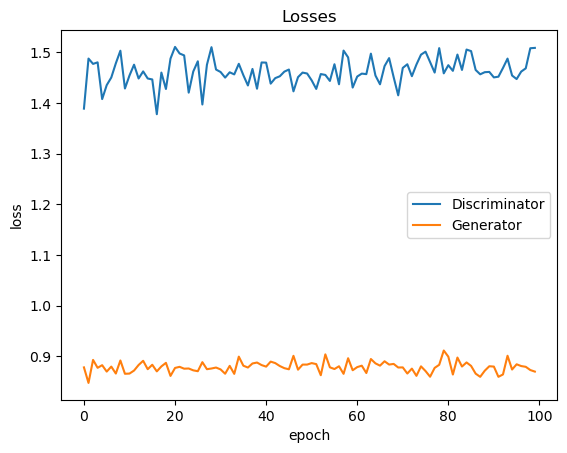

In [20]:
losses_g, losses_d, real_scores, fake_scores = history
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

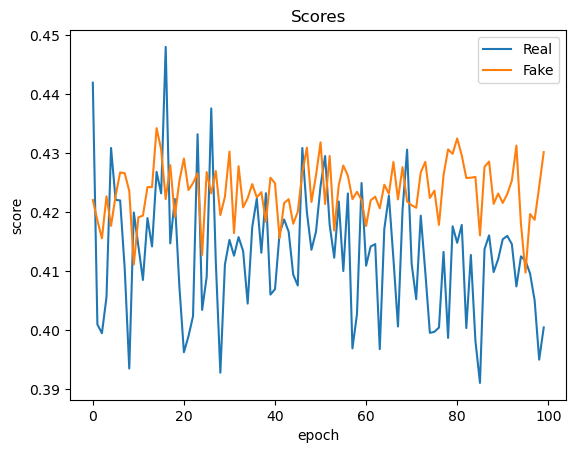

In [21]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Saving the trained model for inferencing
    </div>




In [22]:
torch.save(g_model.state_dict(), 'G.pth')
torch.save(d_model.state_dict(), 'D.pth')

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Inferencing    </div>




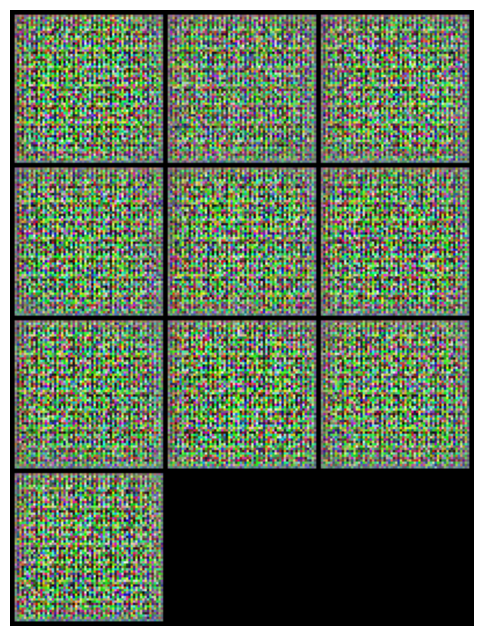

In [23]:
latent_size = 128
generator.eval()

# Generate images
num_images = 10  # Number of images to generate
fixed_latent = torch.randn(num_images, latent_size, 1, 1, device=device)
generated_images = generator(fixed_latent)

generated_images = denorm(generated_images)
grid = make_grid(generated_images.cpu().detach(), nrow=int(num_images ** 0.5))
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()